In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal

%matplotlib inline

import seaborn
import numpy as np

seaborn.set()
np.set_printoptions(precision=4, suppress=True)

pltargs = dict(
    interpolation='nearest', aspect='auto', 
    origin='lower')

In [2]:
cifar_fmt = "/Users/ejhumphrey/Downloads/cifar-10-batches-py/data_batch_{}.npz"

In [3]:
# load all images
x_obs = []
for fname in glob.glob(cifar_fmt.format("*")):
    x_obs += [np.load(fname)['data']]

x_obs = np.concatenate(x_obs, axis=0)
x_gray = x_obs.mean(axis=-1)

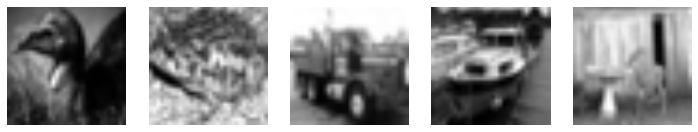

In [5]:
ncols = 5
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(10, 2))
for ax, n in zip(axes, np.random.permutation(len(x_gray))[:ncols]):
    ax.imshow(x_gray[n], cmap=plt.cm.gray)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()
plt.tight_layout()

In [6]:
x_mean = x_gray.mean(axis=0)
x_var = x_gray.var(axis=0)
x_centered = x_gray - x_mean

In [7]:
n = 11
x_dim = 12
y_dim = 12

z = signal.correlate2d(x_centered[n], 
                       x_centered[n, x_dim:-x_dim, y_dim:-y_dim], 
                       mode='valid') 

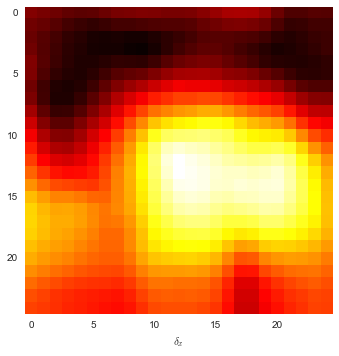

In [22]:
fig, ax = plt.subplots(1, 1, )
ax.imshow(z, interpolation='nearest', aspect='equal', cmap=plt.cm.hot)
ax.set_xlabel(r'$\delta_x$')
ax.grid(alpha=0)

In [200]:
x_dim = 12
y_dim = 12
img_corr = np.array([signal.correlate2d(x, x[x_dim:-x_dim, y_dim:-y_dim], mode='valid') 
                     for x in x_centered])

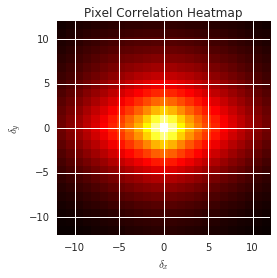

In [206]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img_corr.mean(axis=0), 
          interpolation='nearest', cmap=plt.cm.hot,
          extent=(-x_dim, x_dim, -y_dim, y_dim))
ax.set_xlabel(r'$\delta_x$')
ax.set_ylabel(r'$\delta_y$')
ax.set_title("Pixel Correlation Heatmap")
plt.tight_layout()

In [79]:
npz_files = glob.glob("/Users/ejhumphrey/data/cqt/*npz")
len(npz_files)

21052

In [81]:
# Build a dataframe for the streamer
# and backfill an instrument so the streamer will still work...
recs = [dict(cqt=fname, instrument='flute') for fname in npz_files]
dframe = pd.DataFrame.from_records(recs)

In [91]:
import wcqtlib.train.streams as S
import pescador

In [124]:
seeds = [pescador.Streamer(S.cqt_slices, row, t_len=20) 
         for idx, row in dframe.iterrows()]
stream = pescador.mux(seeds, None, k=10, lam=1)

In [125]:
x_cqt = np.concatenate([next(stream)['x_in'][0] 
                        for n in range(20000)], axis=0)

In [126]:
x_cqt.shape

(20000, 20, 204)

In [127]:
x_centered = np.log1p(50*x_cqt) - np.log1p(50*x_cqt).mean(axis=0)

(13, 97)


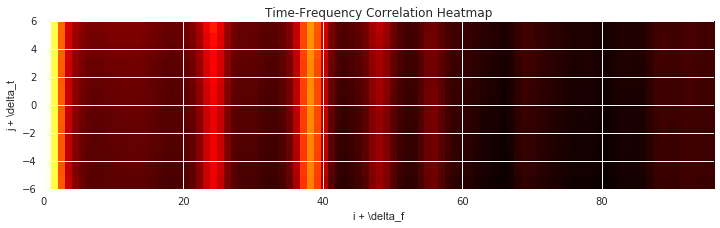

In [168]:
n = 202
bpo = 24
n_oct = 2
fdim = (n_oct*bpo)
tdim = 6
z = signal.correlate2d(x_centered[n], x_centered[n, tdim:-tdim, 0:-fdim*2], mode='valid')
print(z.shape)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.imshow(z, interpolation='nearest', aspect='auto',
          cmap=plt.cm.hot,
          extent=(0, fdim*2, -6, 6))
ax.set_xlabel("i + \delta_f")
ax.set_ylabel("j + \delta_t")
ax.set_title("Time-Frequency Correlation Heatmap")

In [113]:
z.shape

(9, 311)

$C[n, m] = \frac{1}{IJK}\sum_{i=0}^{I-1}\sum_{j=0}^{J-1} \sum_{k=0}^{K-1} \bar{X}_i[j, k] * \bar{X}_i[j + n, k + m]$

$Y_i[n, m] = \frac{1}{JK}\sum_j \sum_k X_i[j, k] * X_i[j + n, k + m]$

i would expect to see 
E[(S[t, f] - mu[t, f]) * (S[t + x, f + y] - mu[t + f, mu + y])] where (x, y) range in +- MAX_FILTER_SIZE, and (t, f) range over the feasible region of the input

In [155]:
bpo = 24
n_oct = 2
tdim = 6
fdim = (n_oct*bpo)
z_corr = np.array([signal.correlate2d(x, x[tdim:-tdim, fdim:-fdim], 
                                      mode='valid') 
                   for x in x_centered])

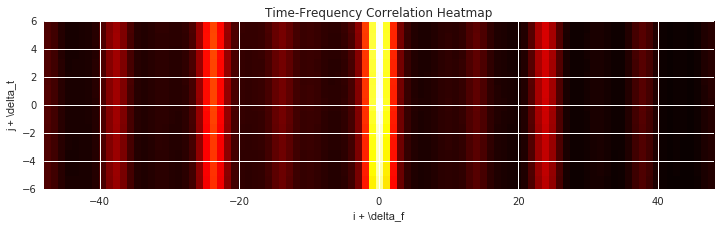

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.imshow(z_corr.mean(axis=0), interpolation='nearest', aspect='auto',
          cmap=plt.cm.hot,
          extent=(-fdim, fdim, -tdim, tdim))
ax.set_xlabel("i + \delta_f")
ax.set_ylabel("j + \delta_t")
ax.set_title("Time-Frequency Correlation Heatmap")

In [169]:
bpo = 24
n_oct = 2
tdim = 6

fdim = (n_oct*bpo)
z_corr_asym = np.array([signal.correlate2d(x, x[tdim:-tdim, 0:-2*fdim], 
                                      mode='valid') 
                        for x in x_centered])

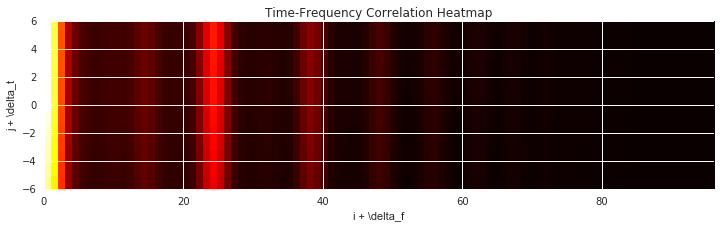

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.imshow(z_corr_asym.mean(axis=0), interpolation='nearest', aspect='auto',
          cmap=plt.cm.hot,
          extent=(0, 2*fdim, -tdim, tdim))
ax.set_xlabel("i + \delta_f")
ax.set_ylabel("j + \delta_t")
ax.set_title("Time-Frequency Correlation Heatmap")

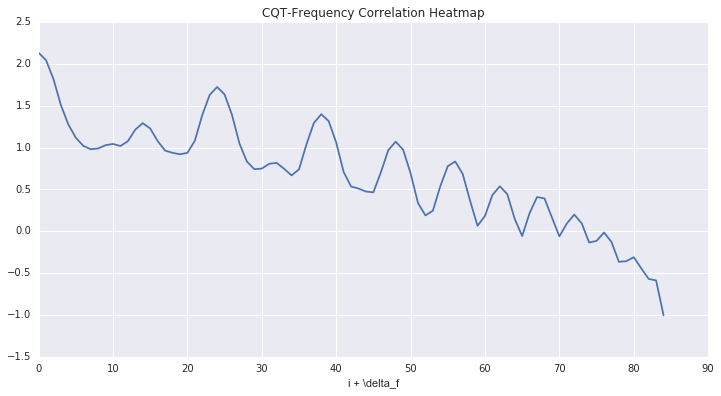

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(fdim*2 + 1), np.log10(0.001 + z_corr_asym.mean(axis=0).mean(axis=0)))
ax.set_xlabel("i + \delta_f")
ax.set_title("CQT-Frequency Correlation Heatmap")

In [181]:
npz_files = glob.glob("/Volumes/camel/chordrec/cqts/*npz")
print(len(npz_files))
# Build a dataframe for the streamer
# and backfill an instrument so the streamer will still work...
recs = [dict(cqt=fname, instrument='flute') for fname in npz_files]
dframe = pd.DataFrame.from_records(recs)

302


In [182]:
seeds = [pescador.Streamer(S.cqt_slices, row, t_len=20) 
         for idx, row in dframe.iterrows()]
stream = pescador.mux(seeds, None, k=50, lam=50)

In [183]:
x_cqt = np.concatenate([next(stream)['x_in'][0] 
                        for n in range(25000)], axis=0)
print(x_cqt.shape)

(25000, 20, 204)


In [184]:
x_centered = np.log1p(50*x_cqt) - np.log1p(50*x_cqt).mean(axis=0)

In [185]:
# Symmetrical autocorr
bpo = 24
n_oct = 2
tdim = 6
fdim = (n_oct*bpo)
z_corr = np.array([signal.correlate2d(x, x[tdim:-tdim, fdim:-fdim], 
                                      mode='valid') 
                   for x in x_centered])

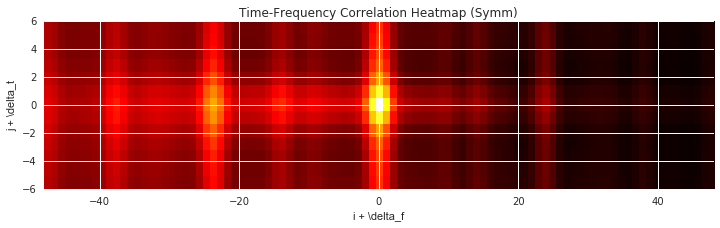

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.imshow(z_corr.mean(axis=0), interpolation='nearest', aspect='auto',
          cmap=plt.cm.hot,
          extent=(-fdim, fdim, -tdim, tdim))
ax.set_xlabel("i + \delta_f")
ax.set_ylabel("j + \delta_t")
ax.set_title("Time-Frequency Correlation Heatmap (Symm)")

In [187]:
# Asymmetrical autocorr
bpo = 24
n_oct = 2
tdim = 6

fdim = (n_oct*bpo)
z_corr_asym = np.array([signal.correlate2d(x, x[tdim:-tdim, 0:-2*fdim], 
                                      mode='valid') 
                        for x in x_centered])

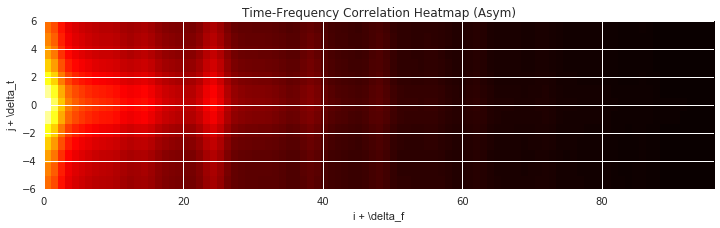

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.imshow(z_corr_asym.mean(axis=0), interpolation='nearest', aspect='auto',
          cmap=plt.cm.hot,
          extent=(0, 2*fdim, -tdim, tdim))
ax.set_xlabel("i + \delta_f")
ax.set_ylabel("j + \delta_t")
ax.set_title("Time-Frequency Correlation Heatmap (Asym)")